In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split



# Step 2: Load the dataset from Google Drive
# Change 'merged_dataset.csv' to your file path inside Google Drive
# For example: 'drive/MyDrive/project_folder/merged_dataset.csv'
dataset_path = '/content/drive/MyDrive/projet_recomendation/new_merged_file.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(dataset_path)

In [3]:
interaction_matrix = df.pivot_table(index='userId', columns='movieId', values='rating')

In [4]:
interaction_matrix = interaction_matrix.fillna(0)

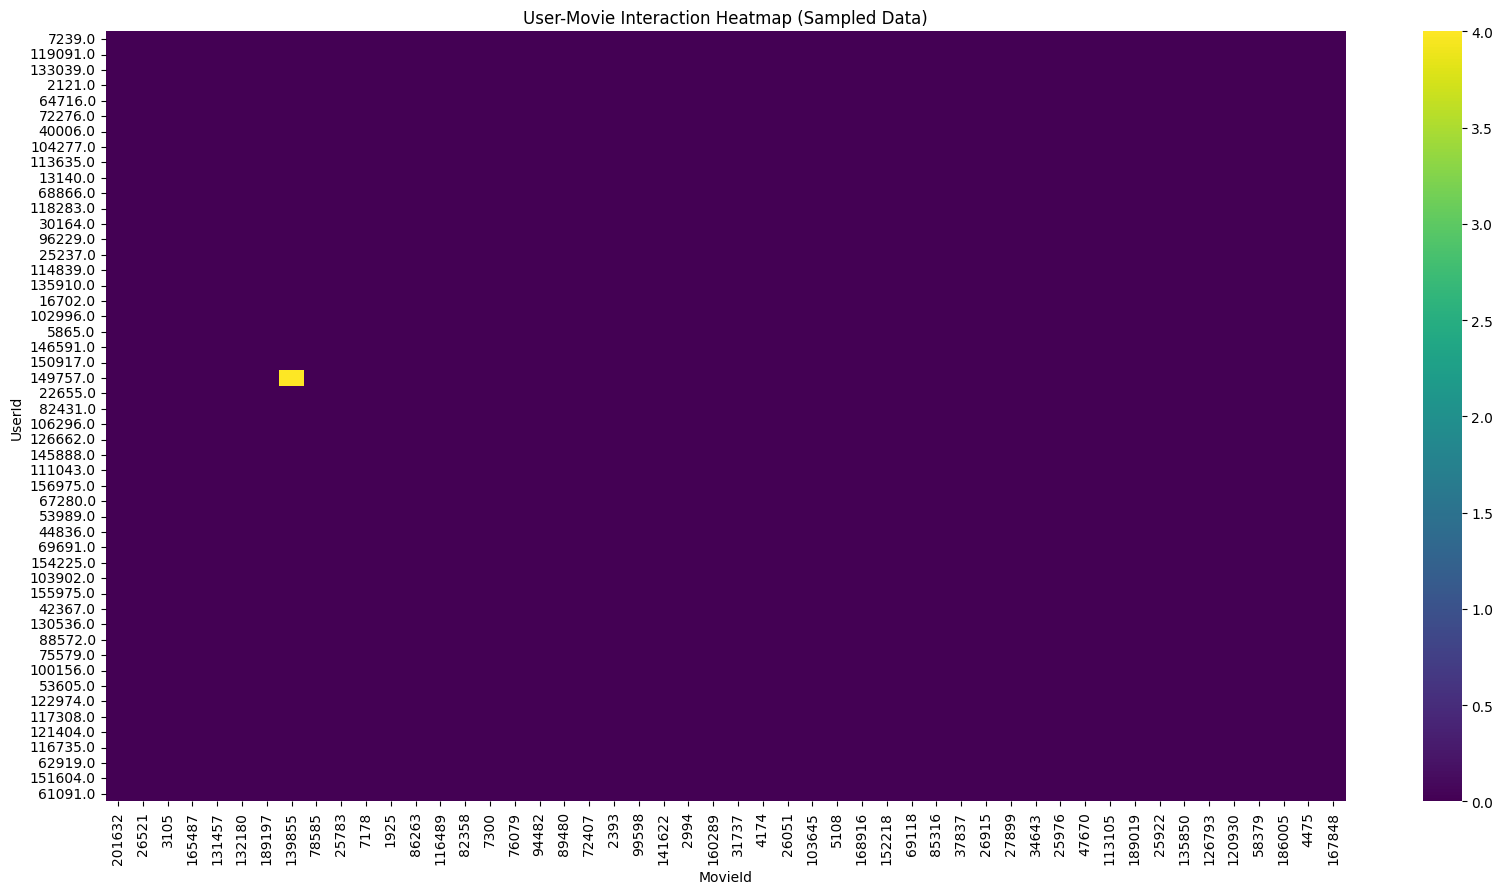

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sample_interaction_matrix = interaction_matrix.sample(n=50, axis=0).sample(n=50, axis=1)

plt.figure(figsize=(20, 10))
sns.heatmap(sample_interaction_matrix, cmap='viridis', cbar=True)
plt.title('User-Movie Interaction Heatmap (Sampled Data)')
plt.xlabel('MovieId')
plt.ylabel('UserId')
plt.show()

In [6]:
user_profiles = df.groupby('userId').agg({
    'movieId': lambda x: list(x),  # List of movies each user interacted with
    'rating': 'mean',              # Average rating given by each user
    'tag': lambda x: list(x),      # List of tags for all movies watched by the user
    'genres': lambda x: list(x)    # List of genres for all movies watched by the user
}).reset_index()

In [7]:
grouped_save_path = '/content/drive/MyDrive/projet_recomendation/grouped_by_userid.csv'
user_profiles.to_csv(grouped_save_path, index=False)
print(f"User profiles saved to: {grouped_save_path}")


User profiles saved to: /content/drive/MyDrive/projet_recomendation/grouped_by_userid.csv


In [8]:
interaction_data = sample_interaction_matrix.stack().reset_index()
interaction_data.columns = ['userId', 'movieId', 'rating']


In [9]:
train_data, test_data = train_test_split(interaction_data, test_size=0.2, random_state=42)

In [10]:
train_user_ids = torch.tensor(train_data['userId'].values, dtype=torch.long)
train_movie_ids = torch.tensor(train_data['movieId'].values, dtype=torch.long)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32)

test_user_ids = torch.tensor(test_data['userId'].values, dtype=torch.long)
test_movie_ids = torch.tensor(test_data['movieId'].values, dtype=torch.long)
test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float32)


In [11]:
print(f"Training data: {len(train_user_ids)} rows")
print(f"Test data: {len(test_user_ids)} rows")

# Step 10: Save the Interaction Data (Optional)
interaction_save_path = '/content/drive/MyDrive/projet_recomendation/processed_interaction_data.csv'
interaction_data.to_csv(interaction_save_path, index=False)
print(f"Processed interaction data saved to: {interaction_save_path}")

Training data: 2000 rows
Test data: 500 rows
Processed interaction data saved to: /content/drive/MyDrive/projet_recomendation/processed_interaction_data.csv


In [12]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=daa47d2014a4457b072f8868bdd69c63188cd0d1da5e93c6e698f9e26477bc33
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [4]:
import pandas as pd
import numpy as np
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
import os

# Initialize Spark session
spark = SparkSession.builder.appName('CollaborativeFilteringChunks').getOrCreate()

# Chunk parameters
chunk_size = 5000 # Number of rows per chunk
processed_chunks = []  # List to store processed chunk filenames

# Step 1: Function to process each chunk
def process_chunk(chunk, chunk_id):
    # Step 2: Explode the movieId column
    chunk['movieId'] = chunk['movieId'].apply(lambda x: eval(str(x)))  # Convert the stringified list to actual list
    chunk_exploded = chunk.explode('movieId')  # Explode the movieId list

    # Step 3: Drop any rows with missing values (e.g., if rating is NaN)
    chunk_clean = chunk_exploded.dropna(subset=['rating'])

    # Step 4: Convert to Spark DataFrame
    spark_df = spark.createDataFrame(chunk_clean[['userId', 'movieId', 'rating']])

    # Ensure movieId is of type integer
    spark_df = spark_df.withColumn('movieId', spark_df['movieId'].cast(IntegerType()))

    # Save the cleaned chunk to disk for later use
    chunk_filename = f'processed_chunk_{chunk_id}.parquet'
    spark_df.write.parquet(chunk_filename, mode='overwrite')
    processed_chunks.append(chunk_filename)

# Step 5: Read the dataset in chunks and process each chunk
dataset_path = '/content/drive/MyDrive/projet_recomendation/grouped_by_userid.csv'

for i, chunk in enumerate(pd.read_csv(dataset_path, chunksize=chunk_size)):
    process_chunk(chunk, i)
    print(f'Processed chunk {i+1}')

# Step 6: Load all the processed chunks into a single Spark DataFrame
all_chunks = [spark.read.parquet(chunk_filename) for chunk_filename in processed_chunks]
full_spark_df = all_chunks[0]

for chunk in all_chunks[1:]:
    full_spark_df = full_spark_df.union(chunk)

# Step 7: Split the data into training and test sets
(training, test) = full_spark_df.randomSplit([0.8, 0.2])

# Step 8: Initialize the ALS model
als = ALS(maxIter=10, regParam=0.1, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy="drop")

# Step 9: Train the ALS model
model = als.fit(training)

# Step 10: Evaluate the model using RMSE
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

# Step 11: Make predictions for missing ratings (NaNs in the original matrix)
missing_data = pd.read_csv(dataset_path)
missing_data['movieId'] = missing_data['movieId'].apply(lambda x: eval(str(x)))  # Convert the stringified list to actual list
missing_data_exploded = missing_data.explode('movieId')
missing_spark_df = spark.createDataFrame(missing_data_exploded[['userId', 'movieId']])

# Predict the missing values
missing_predictions = model.transform(missing_spark_df)
missing_predictions.show(10)

# Optional: Save predictions to a CSV
missing_predictions.select('userId', 'movieId', 'prediction').toPandas().to_csv('predicted_ratings.csv', index=False)

print("All tasks completed!")


Processed chunk 1
Processed chunk 2
Processed chunk 3
Root-mean-square error = 0.1100761752760583
+-------+-------+----------+
| userId|movieId|prediction|
+-------+-------+----------+
| 7982.0|  45442| 3.9025164|
| 9427.0|    111|   4.69294|
| 9427.0|    565| 4.6411448|
| 9427.0|   2093|  4.690499|
| 9427.0|   2093|  4.690499|
| 9427.0|   2093|  4.690499|
| 9427.0|   5064| 4.6562505|
| 9427.0|   5064| 4.6562505|
| 9852.0|  68194|  3.904932|
|10362.0|   6935| 4.8814297|
+-------+-------+----------+
only showing top 10 rows

All tasks completed!


In [5]:
# Generate top 10 movie recommendations for each user
user_recommendations = model.recommendForAllUsers(10)
user_recommendations.show(10, truncate=False)

# Save the recommendations to CSV
user_recommendations.toPandas().to_csv('user_recommendations.csv', index=False)


+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                                   |
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|3     |[{184601, 4.579714}, {184559, 4.579714}, {184557, 4.579714}, {184555, 4.579714}, {184541, 4.579714}, {152751, 4.3976326}, {152741, 4.3976326}, {152733, 4.3976326}, {152725, 4.3976326}, {152721, 4.3976326}]     |
|19    |[{184601, 5.7642665}, {184559, 5.7642665}, {184557, 5.7642665}, {184555, 5.7642665}, {184541, 5.7642665}, {15275

In [9]:
# Top 10 recommendations for a specific user (e.g., userId 123)
user_id = 1772
user_subset = full_spark_df.filter(full_spark_df.userId == user_id)
user_recommendations = model.recommendForUserSubset(user_subset, 10)
user_recommendations.show(truncate=False)

# Top 10 similar movies for a specific movie (e.g., movieId 456)
movie_id = 456
movie_subset = full_spark_df.filter(full_spark_df.movieId == movie_id)
movie_recommendations = model.recommendForItemSubset(movie_subset, 10)
movie_recommendations.show(truncate=False)


+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                                   |
+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1772  |[{184601, 1.1652448}, {184559, 1.1652448}, {184557, 1.1652448}, {184555, 1.1652448}, {184541, 1.1652448}, {152751, 1.1193553}, {152741, 1.1193553}, {152733, 1.1193553}, {152725, 1.1193553}, {152721, 1.1193553}]|
+------+----------------------------------------------------------------------------------------------------------------

In [7]:
# Check if the user_id exists in the dataset
user_exists = full_spark_df.filter(full_spark_df.userId == user_id).count() > 0
print(f"Does user {user_id} exist? {user_exists}")


Does user 123 exist? False


In [10]:
# Save the model
model.write().overwrite().save('als_model')

# Load the model later if needed
# from pyspark.ml.recommendation import ALSModel
# model = ALSModel.load('als_model')


In [11]:
# Save the ALS model to a local directory
model_path = "/content/drive/MyDrive/projet_recomendation/als_model"
model.save(model_path)

print(f"Model saved at: {model_path}")


Model saved at: /content/drive/MyDrive/projet_recomendation/als_model
